# Annealing optimizer

The optimizer is used to optimize city blocks of certain land uses by building services of predefined capacity and area.

## Prepare city

The method is time consuming and aimed to work with smaller territories, so we make a smaller model.

In [1]:
from blocksnet import City, AnnealingOptimizer

city = City.from_pickle('../data/model.pickle')

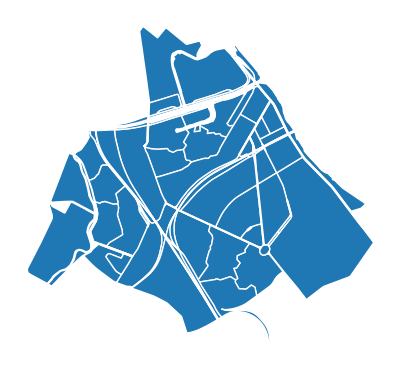

In [2]:
blocks = city.get_blocks_gdf(True)
nearest_blocks = blocks.sjoin_nearest(blocks[blocks.index == 1445], distance_col='distance')
nearest_blocks = nearest_blocks[nearest_blocks['distance']<=1000]
nearest_blocks.plot().set_axis_off()

In [3]:
city._blocks = {i:city[i] for i in nearest_blocks.index}

## Method

In [5]:
import random
from blocksnet import LandUse
from blocksnet.method.land_use_optimizer import LU_INDICATORS

ao = AnnealingOptimizer(city_model=city)
blocks_lu = {block.id : random.choice(list(LandUse)) for block in city.blocks}
blocks_fsi = {b_id : LU_INDICATORS[lu].fsi_min for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_INDICATORS[lu].gsi_min for b_id, lu in blocks_lu.items()}
service_types = {st.name : 1/len(city.service_types) for st in city.service_types}
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.9)

 50%|█████     | 505/1000 [01:12<01:10,  7.01it/s]


In [6]:
print('Best objective value:', value)

Best objective value: 0.5204066996619239


In [7]:
{st : round(value,2)  for st,value in provisions.items()}

{'school': 0.68,
 'kindergarten': 0.6,
 'hospital': 0.0,
 'polyclinic': 0.9,
 'pitch': 1.0,
 'swimming_pool': 1.0,
 'stadium': 0.0,
 'theatre': 1.0,
 'museum': 1.0,
 'cinema': 1.0,
 'mall': 1.0,
 'convenience': 0.56,
 'supermarket': 0.47,
 'cemetery': 0.0,
 'religion': 0.0,
 'market': 1.0,
 'bowling_alley': 1.0,
 'university': 1.0,
 'playground': 0.0,
 'pharmacy': 0.6,
 'fuel': 1.0,
 'beach': 0.0,
 'train_building': 1.0,
 'bank': 1.0,
 'lawyer': 1.0,
 'cafe': 0.0,
 'subway_entrance': 0.83,
 'multifunctional_center': 0.06,
 'hairdresser': 0.32,
 'restaurant': 1.0,
 'bar': 0.34,
 'park': 0.0,
 'government': 1.0,
 'recruitment': 0.0,
 'hotel': 1.0,
 'zoo': 0.0,
 'circus': 1.0,
 'post': 0.2,
 'police': 1.0,
 'dog_park': 1.0,
 'hostel': 0.79,
 'bakery': 1.0,
 'parking': 0.0,
 'guest_house': 0.0,
 'reserve': 0.0,
 'sanatorium': 0.79,
 'embankment': 0.0,
 'machine-building_plant': 0.0,
 'brewery': 0.29,
 'woodworking_plant': 1.0,
 'oil_refinery': 0.0,
 'plant_of_building_materials': 0.79,
 'w

In [10]:
ao.to_bricks_df(X).head()

,block_id,service_type,is_integrated,area,capacity,count
16,39,supermarket,True,300.0,500,1
33,39,woodworking_plant,False,13000.0,500,1
76,40,military_kom,False,4000.0,200,1
88,40,hotel,False,24000.0,300,1
190,40,hostel,False,500.0,50,1


In [9]:
ao.to_gdf(X, indicators).head()

,population,train_station,military_kom,warehouse,fuel,water_works,kindergarten,plant_nursery,hotel,embankment,...,polyclinic,parking,park,school,landfill,hospital,wastewater_plant,train_building,geometry,land_use
block_id,,,,,,,,,,,,,,,,,,,,,
39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352493.392 6644174.577, 352480.316 6...",industrial
40,3113,0.0,200.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352846.893 6643739.658, 352854.917 6...",residential
41,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352713.398 6643353.609, 352656.125 6...",industrial
42,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352661.968 6643879.720, 352637.303 6...",industrial
43,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((353921.529 6644728.862, 353829.106 6...",recreation
